In [36]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time


In [37]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jutepest/sample_submission.csv
/kaggle/input/jutepest/train.csv
/kaggle/input/jutepest/test.csv
/kaggle/input/jutepest/train_images/data_2198.jpg
/kaggle/input/jutepest/train_images/data_4627.jpg
/kaggle/input/jutepest/train_images/data_4335.jpg
/kaggle/input/jutepest/train_images/data_3267.jpg
/kaggle/input/jutepest/train_images/data_6807.jpg
/kaggle/input/jutepest/train_images/data_5147.jpg
/kaggle/input/jutepest/train_images/data_4768.jpg
/kaggle/input/jutepest/train_images/data_3090.jpg
/kaggle/input/jutepest/train_images/data_2961.jpg
/kaggle/input/jutepest/train_images/data_4147.jpg
/kaggle/input/jutepest/train_images/data_548.jpg
/kaggle/input/jutepest/train_images/data_2240.jpg
/kaggle/input/jutepest/train_images/data_1699.jpg
/kaggle/input/jutepest/train_images/data_2939.jpg
/kaggle/input/jutepest/train_images/data_4276.jpg
/kaggle/input/jutepest/train_images/data_2919.jpg
/kaggle/input/jutepest/train_images/data_3086.jpg
/kaggle/input/jutepest/train_images/data_

In [38]:
# Load and preview the dataset
train = pd.read_csv('/kaggle/input/jutepest/train.csv')
train.head()

,filename,class
0,data_813.jpg,Jute Stem Weevil
1,data_6274.jpg,Mealybug
2,data_2317.jpg,Black Hairy
3,data_2124.jpg,Termite
4,data_5974.jpg,Jute Aphid


In [39]:
# Encode class labels to integers
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

In [40]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


In [41]:
# Custom dataset class
class JutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataframe.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [42]:
# Create dataset and split into training and validation sets
train_dir = '/kaggle/input/jutepest/train_images/'
dataset = JutePestDataset(train, train_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

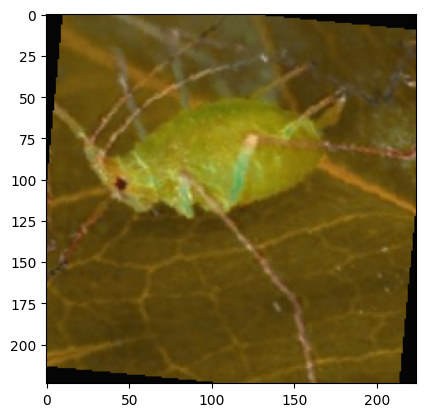

In [43]:
# Display a sample image
plt.imshow(torch.permute(dataset[4][0], (1, 2, 0)))
plt.show()

In [44]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### VGG-Like Model


In [45]:
# Define the custom VGG-like model
class Block(nn.Module):
    def __init__(self, in_channels, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions

        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels if i == 0 else self.filters,
                      out_channels=self.filters,
                      kernel_size=self.kernel_size,
                      padding=1) for i in range(self.repetitions)
        ])
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm2d(self.filters) for _ in range(self.repetitions)
        ])

        self.max_pool = nn.MaxPool2d(kernel_size=pool_size, stride=strides)

    def forward(self, x):
        for conv_layer, bn_layer in zip(self.conv_layers, self.bn_layers):
            x = F.relu(bn_layer(conv_layer(x)))

        x = self.max_pool(x)
        return x

In [46]:
class MyVGG(nn.Module):
    def __init__(self, num_classes):
        super(MyVGG, self).__init__()
        self.block_a = Block(3, 64, 3, 2)
        self.block_b = Block(64, 128, 3, 2)
        self.block_c = Block(128, 256, 3, 3)
        self.block_d = Block(256, 512, 3, 3)
        self.block_e = Block(512, 512, 3, 3)
        self.flatten_a = nn.Flatten()
        self.fc_a = nn.Linear(512 * 7 * 7, 4096)
        self.dropout_a = nn.Dropout(0.5)
        self.fc_b = nn.Linear(4096, 1024)
        self.dropout_b = nn.Dropout(0.5)
        self.fc_c = nn.Linear(1024, 512)
        self.dropout_c = nn.Dropout(0.5)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block_a(x)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten_a(x)
        x = F.relu(self.fc_a(x))
        x = self.dropout_a(x)
        x = F.relu(self.fc_b(x))
        x = self.dropout_b(x)
        x = F.relu(self.fc_c(x))
        x = self.dropout_c(x)
        x = self.classifier(x)
        return x

In [47]:
# Initialize the model, loss function, and optimizer
model = MyVGG(num_classes=17)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

In [48]:
# Print model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MyVGG                                    [32, 17]                  --
├─Block: 1-1                             [32, 64, 112, 112]        --
│    └─ModuleList: 2-3                   --                        (recursive)
│    │    └─Conv2d: 3-1                  [32, 64, 224, 224]        1,792
│    └─ModuleList: 2-4                   --                        (recursive)
│    │    └─BatchNorm2d: 3-2             [32, 64, 224, 224]        128
│    └─ModuleList: 2-3                   --                        (recursive)
│    │    └─Conv2d: 3-3                  [32, 64, 224, 224]        36,928
│    └─ModuleList: 2-4                   --                        (recursive)
│    │    └─BatchNorm2d: 3-4             [32, 64, 224, 224]        128
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
├─Block: 1-2                             [32, 128, 56, 56]         --
│    └─ModuleList: 2-8                  

In [49]:
# Determine the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

MyVGG(
  (block_a): Block(
    (conv_layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn_layers): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_b): Block(
    (conv_layers): ModuleList(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn_layers): ModuleList(
      (0-1): 2 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_c): Block(
    (conv_layers): ModuleList(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

In [50]:
# Fungsi untuk menghitung akurasi
def calc_accuracy(true, pred):
    pred = F.softmax(pred, dim=1)
    acc = (true == pred.argmax(dim=1)).float().mean().item()
    return round(acc * 100, 2)

In [71]:
# Fungsi untuk menghitung F1 Score
def calc_f1_score(true, pred):
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    true = true.cpu().numpy()
    pred = pred.cpu().numpy()
    return f1_score(true, pred, average='weighted')

## Melanjutkan Epoch Sebelumnya


In [51]:
checkpoint_path = ''

# Check if checkpoint exists
if os.path.exists(checkpoint_path) and checkpoint_path:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    print(f"Checkpoint loaded, starting from epoch {start_epoch}")
else:
    # Initialize training and validation statistics
    start_epoch = 0
    best_val_loss = np.inf
    patience_counter = 0
    print("No checkpoint found, starting from scratch")

No checkpoint found, starting from scratch


## Training

In [52]:
# Initialize training and validation statistics
train_loss = []
train_accuracy = []
train_f1_score = []
val_loss = []
val_accuracy = []
val_f1_score = []
epochs = 100
patience = 6

In [ ]:
# Determine the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [53]:
# Training loop
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    train_epoch_f1_score = []
    val_epoch_loss = []
    val_epoch_accuracy = []
    val_epoch_f1_score = []

    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss.append(loss.item())
            train_epoch_accuracy.append(acc)
            train_epoch_f1_score.append(f1)

            pbar.set_postfix({'Training Loss': np.mean(train_epoch_loss), 'Training Accuracy': np.mean(train_epoch_accuracy), 'Training F1 Score': np.mean(train_epoch_f1_score)})
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)

            val_epoch_loss.append(loss.item())
            val_epoch_accuracy.append(acc)
            val_epoch_f1_score.append(f1)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    train_epoch_f1_score = np.mean(train_epoch_f1_score)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_f1_score = np.mean(val_epoch_f1_score)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1_score.append(train_epoch_f1_score)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1_score.append(val_epoch_f1_score)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2f}%, Training F1 Score: {train_epoch_f1_score:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%, Validation F1 Score: {val_epoch_f1_score:.2f}, Epoch Duration: {epoch_duration:.2f} seconds")

    # Save the model and optimizer state every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
        print(f'Model saved at epoch {epoch + 1}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1} due to early stopping')
            break

    lr_scheduler.step()

Epoch 1/100: 100%|██████████| 154/154 [01:29<00:00,  1.73batch/s, Training Loss=2.83, Training Accuracy=9.08]


Epoch 1/100, Training Loss: 2.8250, Training Accuracy: 9.08%
Validation Loss: 2.6026, Validation Accuracy: 16.39%, Epoch Duration: 103.86 seconds
Best model saved


Epoch 2/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=2.63, Training Accuracy=13.2]


Epoch 2/100, Training Loss: 2.6345, Training Accuracy: 13.23%
Validation Loss: 2.5062, Validation Accuracy: 17.97%, Epoch Duration: 102.51 seconds
Best model saved


Epoch 3/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=2.5, Training Accuracy=18.3] 


Epoch 3/100, Training Loss: 2.4958, Training Accuracy: 18.26%
Validation Loss: 2.3361, Validation Accuracy: 21.68%, Epoch Duration: 102.61 seconds
Best model saved


Epoch 4/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=2.4, Training Accuracy=22.5] 


Epoch 4/100, Training Loss: 2.4006, Training Accuracy: 22.52%
Validation Loss: 2.2619, Validation Accuracy: 26.56%, Epoch Duration: 102.24 seconds
Best model saved


Epoch 5/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=2.28, Training Accuracy=25.9]


Epoch 5/100, Training Loss: 2.2809, Training Accuracy: 25.91%
Validation Loss: 2.1271, Validation Accuracy: 30.65%, Epoch Duration: 101.99 seconds
Best model saved


Epoch 6/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=2.16, Training Accuracy=29.6]


Epoch 6/100, Training Loss: 2.1616, Training Accuracy: 29.57%
Validation Loss: 2.0667, Validation Accuracy: 33.94%, Epoch Duration: 101.87 seconds
Best model saved


Epoch 7/100: 100%|██████████| 154/154 [01:27<00:00,  1.77batch/s, Training Loss=2.09, Training Accuracy=32.8]


Epoch 7/100, Training Loss: 2.0886, Training Accuracy: 32.77%
Validation Loss: 2.0233, Validation Accuracy: 36.31%, Epoch Duration: 101.48 seconds
Best model saved


Epoch 8/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=2.01, Training Accuracy=34.2]


Epoch 8/100, Training Loss: 2.0129, Training Accuracy: 34.18%
Validation Loss: 1.8220, Validation Accuracy: 42.74%, Epoch Duration: 102.13 seconds
Best model saved


Epoch 9/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=1.95, Training Accuracy=37.2]


Epoch 9/100, Training Loss: 1.9524, Training Accuracy: 37.16%
Validation Loss: 1.7953, Validation Accuracy: 41.59%, Epoch Duration: 102.63 seconds
Best model saved


Epoch 10/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=1.89, Training Accuracy=38.9]


Epoch 10/100, Training Loss: 1.8877, Training Accuracy: 38.90%
Validation Loss: 1.8268, Validation Accuracy: 39.89%, Epoch Duration: 103.64 seconds
Model saved at epoch 10


Epoch 11/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=1.78, Training Accuracy=42.4]


Epoch 11/100, Training Loss: 1.7841, Training Accuracy: 42.36%
Validation Loss: 1.6682, Validation Accuracy: 46.19%, Epoch Duration: 103.11 seconds
Best model saved


Epoch 12/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=1.72, Training Accuracy=45]  


Epoch 12/100, Training Loss: 1.7179, Training Accuracy: 44.97%
Validation Loss: 1.5986, Validation Accuracy: 49.91%, Epoch Duration: 102.98 seconds
Best model saved


Epoch 13/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=1.64, Training Accuracy=46.5]


Epoch 13/100, Training Loss: 1.6383, Training Accuracy: 46.49%
Validation Loss: 1.5936, Validation Accuracy: 50.38%, Epoch Duration: 102.16 seconds
Best model saved


Epoch 14/100: 100%|██████████| 154/154 [01:26<00:00,  1.77batch/s, Training Loss=1.63, Training Accuracy=47.6]


Epoch 14/100, Training Loss: 1.6287, Training Accuracy: 47.59%
Validation Loss: 1.5087, Validation Accuracy: 51.90%, Epoch Duration: 101.89 seconds
Best model saved


Epoch 15/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=1.55, Training Accuracy=50.3]


Epoch 15/100, Training Loss: 1.5474, Training Accuracy: 50.29%
Validation Loss: 1.5612, Validation Accuracy: 48.88%, Epoch Duration: 102.64 seconds


Epoch 16/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=1.44, Training Accuracy=53.9]


Epoch 16/100, Training Loss: 1.4436, Training Accuracy: 53.94%
Validation Loss: 1.3026, Validation Accuracy: 58.93%, Epoch Duration: 102.90 seconds
Best model saved


Epoch 17/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=1.37, Training Accuracy=56]  


Epoch 17/100, Training Loss: 1.3682, Training Accuracy: 56.05%
Validation Loss: 1.2653, Validation Accuracy: 59.33%, Epoch Duration: 102.21 seconds
Best model saved


Epoch 18/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=1.34, Training Accuracy=57.3]


Epoch 18/100, Training Loss: 1.3433, Training Accuracy: 57.31%
Validation Loss: 1.2408, Validation Accuracy: 60.71%, Epoch Duration: 102.00 seconds
Best model saved


Epoch 19/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=1.3, Training Accuracy=58.8] 


Epoch 19/100, Training Loss: 1.3018, Training Accuracy: 58.81%
Validation Loss: 1.1407, Validation Accuracy: 66.05%, Epoch Duration: 102.50 seconds
Best model saved


Epoch 20/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=1.26, Training Accuracy=59.9]


Epoch 20/100, Training Loss: 1.2602, Training Accuracy: 59.95%
Validation Loss: 1.1558, Validation Accuracy: 63.54%, Epoch Duration: 102.31 seconds
Model saved at epoch 20


Epoch 21/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=1.16, Training Accuracy=62.6]


Epoch 21/100, Training Loss: 1.1634, Training Accuracy: 62.61%
Validation Loss: 1.0183, Validation Accuracy: 69.68%, Epoch Duration: 101.93 seconds
Best model saved


Epoch 22/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=1.1, Training Accuracy=65.5] 


Epoch 22/100, Training Loss: 1.0987, Training Accuracy: 65.48%
Validation Loss: 1.0103, Validation Accuracy: 69.39%, Epoch Duration: 101.85 seconds
Best model saved


Epoch 23/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=1.05, Training Accuracy=66.1]


Epoch 23/100, Training Loss: 1.0536, Training Accuracy: 66.11%
Validation Loss: 1.0299, Validation Accuracy: 67.41%, Epoch Duration: 102.67 seconds


Epoch 24/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=1.02, Training Accuracy=67]  


Epoch 24/100, Training Loss: 1.0227, Training Accuracy: 67.03%
Validation Loss: 0.9566, Validation Accuracy: 70.03%, Epoch Duration: 102.48 seconds
Best model saved


Epoch 25/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.987, Training Accuracy=68.4]


Epoch 25/100, Training Loss: 0.9871, Training Accuracy: 68.44%
Validation Loss: 1.0044, Validation Accuracy: 70.19%, Epoch Duration: 102.58 seconds


Epoch 26/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.903, Training Accuracy=71.4]


Epoch 26/100, Training Loss: 0.9027, Training Accuracy: 71.42%
Validation Loss: 0.8403, Validation Accuracy: 74.14%, Epoch Duration: 102.86 seconds
Best model saved


Epoch 27/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.879, Training Accuracy=72.5]


Epoch 27/100, Training Loss: 0.8795, Training Accuracy: 72.52%
Validation Loss: 0.8004, Validation Accuracy: 74.81%, Epoch Duration: 102.45 seconds
Best model saved


Epoch 28/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.816, Training Accuracy=73.7]


Epoch 28/100, Training Loss: 0.8157, Training Accuracy: 73.73%
Validation Loss: 0.7573, Validation Accuracy: 76.75%, Epoch Duration: 102.34 seconds
Best model saved


Epoch 29/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.792, Training Accuracy=74.7]


Epoch 29/100, Training Loss: 0.7916, Training Accuracy: 74.66%
Validation Loss: 0.7937, Validation Accuracy: 76.30%, Epoch Duration: 102.14 seconds


Epoch 30/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.781, Training Accuracy=75.8]


Epoch 30/100, Training Loss: 0.7813, Training Accuracy: 75.78%
Validation Loss: 0.7986, Validation Accuracy: 76.43%, Epoch Duration: 101.87 seconds
Model saved at epoch 30


Epoch 31/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.723, Training Accuracy=77.2]


Epoch 31/100, Training Loss: 0.7226, Training Accuracy: 77.19%
Validation Loss: 0.6802, Validation Accuracy: 79.61%, Epoch Duration: 102.41 seconds
Best model saved


Epoch 32/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.688, Training Accuracy=78.2]


Epoch 32/100, Training Loss: 0.6880, Training Accuracy: 78.16%
Validation Loss: 0.6788, Validation Accuracy: 81.08%, Epoch Duration: 102.79 seconds
Best model saved


Epoch 33/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.651, Training Accuracy=79.8]


Epoch 33/100, Training Loss: 0.6513, Training Accuracy: 79.76%
Validation Loss: 0.7313, Validation Accuracy: 80.28%, Epoch Duration: 102.72 seconds


Epoch 34/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.671, Training Accuracy=79.2]


Epoch 34/100, Training Loss: 0.6707, Training Accuracy: 79.18%
Validation Loss: 0.6546, Validation Accuracy: 80.76%, Epoch Duration: 102.77 seconds
Best model saved


Epoch 35/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.621, Training Accuracy=81]  


Epoch 35/100, Training Loss: 0.6210, Training Accuracy: 80.97%
Validation Loss: 0.6610, Validation Accuracy: 80.57%, Epoch Duration: 102.46 seconds


Epoch 36/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.591, Training Accuracy=82.1]


Epoch 36/100, Training Loss: 0.5910, Training Accuracy: 82.10%
Validation Loss: 0.5992, Validation Accuracy: 81.99%, Epoch Duration: 102.27 seconds
Best model saved


Epoch 37/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.555, Training Accuracy=82.6]


Epoch 37/100, Training Loss: 0.5546, Training Accuracy: 82.56%
Validation Loss: 0.6378, Validation Accuracy: 82.26%, Epoch Duration: 102.21 seconds


Epoch 38/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.533, Training Accuracy=83.1]


Epoch 38/100, Training Loss: 0.5327, Training Accuracy: 83.08%
Validation Loss: 0.5798, Validation Accuracy: 83.48%, Epoch Duration: 102.38 seconds
Best model saved


Epoch 39/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.518, Training Accuracy=83.4]


Epoch 39/100, Training Loss: 0.5184, Training Accuracy: 83.44%
Validation Loss: 0.5871, Validation Accuracy: 83.22%, Epoch Duration: 102.80 seconds


Epoch 40/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.53, Training Accuracy=83.3] 


Epoch 40/100, Training Loss: 0.5302, Training Accuracy: 83.26%
Validation Loss: 0.5770, Validation Accuracy: 84.20%, Epoch Duration: 101.97 seconds
Model saved at epoch 40
Best model saved


Epoch 41/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.483, Training Accuracy=84.9]


Epoch 41/100, Training Loss: 0.4825, Training Accuracy: 84.87%
Validation Loss: 0.5437, Validation Accuracy: 84.58%, Epoch Duration: 102.44 seconds
Best model saved


Epoch 42/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.479, Training Accuracy=84.8]


Epoch 42/100, Training Loss: 0.4786, Training Accuracy: 84.76%
Validation Loss: 0.5543, Validation Accuracy: 83.86%, Epoch Duration: 102.46 seconds


Epoch 43/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.482, Training Accuracy=85.4]


Epoch 43/100, Training Loss: 0.4818, Training Accuracy: 85.42%
Validation Loss: 0.5401, Validation Accuracy: 84.68%, Epoch Duration: 102.52 seconds
Best model saved


Epoch 44/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=0.452, Training Accuracy=85.7]


Epoch 44/100, Training Loss: 0.4516, Training Accuracy: 85.71%
Validation Loss: 0.5620, Validation Accuracy: 83.75%, Epoch Duration: 103.21 seconds


Epoch 45/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.454, Training Accuracy=85.2]


Epoch 45/100, Training Loss: 0.4536, Training Accuracy: 85.21%
Validation Loss: 0.5199, Validation Accuracy: 85.00%, Epoch Duration: 103.09 seconds
Best model saved


Epoch 46/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.434, Training Accuracy=86.2]


Epoch 46/100, Training Loss: 0.4339, Training Accuracy: 86.24%
Validation Loss: 0.4976, Validation Accuracy: 85.67%, Epoch Duration: 102.21 seconds
Best model saved


Epoch 47/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.408, Training Accuracy=87.2]


Epoch 47/100, Training Loss: 0.4075, Training Accuracy: 87.19%
Validation Loss: 0.5107, Validation Accuracy: 85.27%, Epoch Duration: 102.56 seconds


Epoch 48/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.413, Training Accuracy=86.9]


Epoch 48/100, Training Loss: 0.4130, Training Accuracy: 86.90%
Validation Loss: 0.5286, Validation Accuracy: 85.33%, Epoch Duration: 102.62 seconds


Epoch 49/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.421, Training Accuracy=87]  


Epoch 49/100, Training Loss: 0.4212, Training Accuracy: 86.99%
Validation Loss: 0.5493, Validation Accuracy: 84.68%, Epoch Duration: 102.52 seconds


Epoch 50/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.403, Training Accuracy=87.9]


Epoch 50/100, Training Loss: 0.4025, Training Accuracy: 87.91%
Validation Loss: 0.5106, Validation Accuracy: 85.16%, Epoch Duration: 102.24 seconds
Model saved at epoch 50


Epoch 51/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.372, Training Accuracy=88.2]


Epoch 51/100, Training Loss: 0.3723, Training Accuracy: 88.19%
Validation Loss: 0.4870, Validation Accuracy: 85.83%, Epoch Duration: 103.68 seconds
Best model saved


Epoch 52/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.37, Training Accuracy=88.3] 


Epoch 52/100, Training Loss: 0.3695, Training Accuracy: 88.31%
Validation Loss: 0.5216, Validation Accuracy: 84.07%, Epoch Duration: 103.16 seconds


Epoch 53/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.367, Training Accuracy=88.7]


Epoch 53/100, Training Loss: 0.3665, Training Accuracy: 88.67%
Validation Loss: 0.5176, Validation Accuracy: 85.08%, Epoch Duration: 102.25 seconds


Epoch 54/100: 100%|██████████| 154/154 [01:27<00:00,  1.75batch/s, Training Loss=0.359, Training Accuracy=88.4]


Epoch 54/100, Training Loss: 0.3586, Training Accuracy: 88.35%
Validation Loss: 0.4663, Validation Accuracy: 87.19%, Epoch Duration: 102.32 seconds
Best model saved


Epoch 55/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.348, Training Accuracy=88.9]


Epoch 55/100, Training Loss: 0.3485, Training Accuracy: 88.89%
Validation Loss: 0.4613, Validation Accuracy: 87.25%, Epoch Duration: 102.70 seconds
Best model saved


Epoch 56/100: 100%|██████████| 154/154 [01:29<00:00,  1.73batch/s, Training Loss=0.346, Training Accuracy=89.2]


Epoch 56/100, Training Loss: 0.3463, Training Accuracy: 89.16%
Validation Loss: 0.4706, Validation Accuracy: 86.95%, Epoch Duration: 103.39 seconds


Epoch 57/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.339, Training Accuracy=89.2]


Epoch 57/100, Training Loss: 0.3390, Training Accuracy: 89.24%
Validation Loss: 0.4667, Validation Accuracy: 87.89%, Epoch Duration: 103.03 seconds


Epoch 58/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.337, Training Accuracy=89.2]


Epoch 58/100, Training Loss: 0.3365, Training Accuracy: 89.20%
Validation Loss: 0.4592, Validation Accuracy: 87.11%, Epoch Duration: 103.02 seconds
Best model saved


Epoch 59/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.326, Training Accuracy=89.4]


Epoch 59/100, Training Loss: 0.3258, Training Accuracy: 89.41%
Validation Loss: 0.4778, Validation Accuracy: 87.21%, Epoch Duration: 102.41 seconds


Epoch 60/100: 100%|██████████| 154/154 [01:28<00:00,  1.75batch/s, Training Loss=0.327, Training Accuracy=89.8]


Epoch 60/100, Training Loss: 0.3272, Training Accuracy: 89.85%
Validation Loss: 0.4798, Validation Accuracy: 85.91%, Epoch Duration: 102.49 seconds
Model saved at epoch 60


Epoch 61/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.324, Training Accuracy=90.1]


Epoch 61/100, Training Loss: 0.3242, Training Accuracy: 90.07%
Validation Loss: 0.5043, Validation Accuracy: 86.71%, Epoch Duration: 102.21 seconds


Epoch 62/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.315, Training Accuracy=90]  


Epoch 62/100, Training Loss: 0.3148, Training Accuracy: 89.98%
Validation Loss: 0.4655, Validation Accuracy: 87.11%, Epoch Duration: 102.70 seconds


Epoch 63/100: 100%|██████████| 154/154 [01:27<00:00,  1.76batch/s, Training Loss=0.287, Training Accuracy=91.1]


Epoch 63/100, Training Loss: 0.2866, Training Accuracy: 91.10%
Validation Loss: 0.4648, Validation Accuracy: 87.25%, Epoch Duration: 101.57 seconds
Early stopping triggered


In [54]:
# Save the checkpoint at the last epoch if not already saved
if (epoch + 1) % 10 != 0 and (epoch + 1) != epochs:
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    print(f'Model saved at the final epoch {epoch + 1}')

Model saved at the final epoch 63


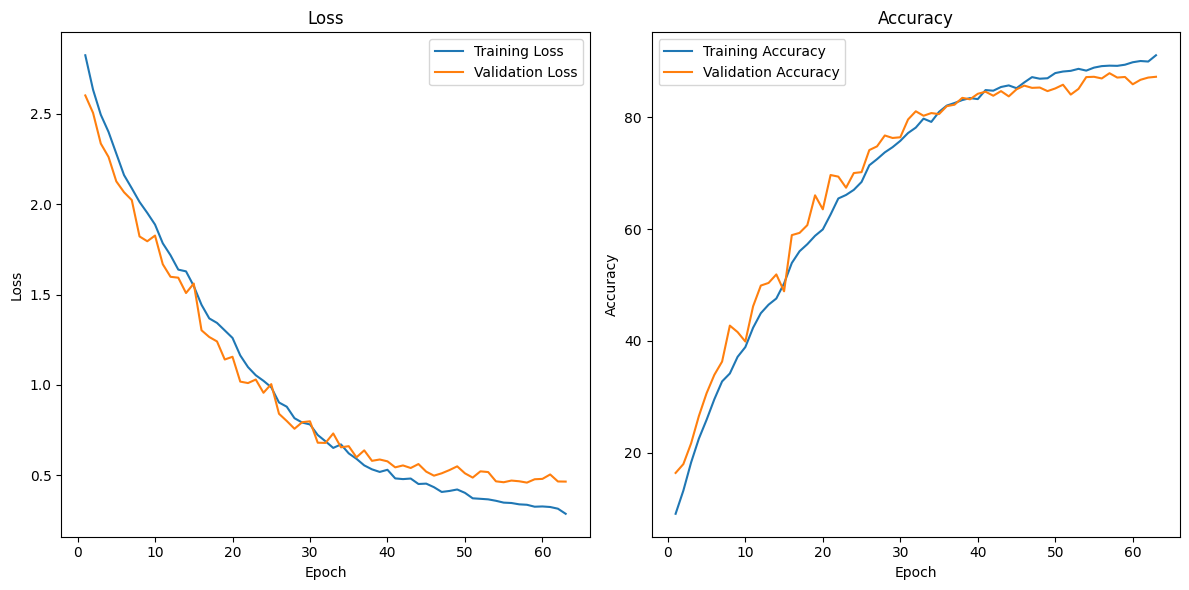

In [62]:
# Plotting the loss, accuracy, and F1 score
actual_epochs = len(train_loss)

epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training & validation loss values
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation F1 score values
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [63]:
# Define the test dataset class
class TestJutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

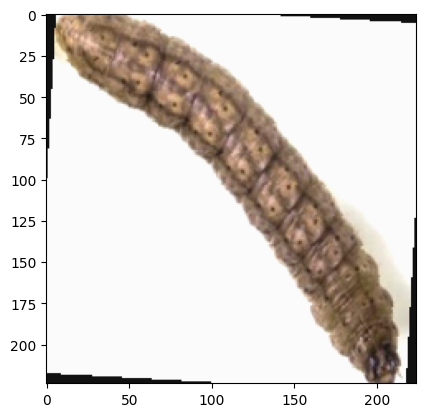

In [64]:
# Load and prepare test dataset
test_dir = '/kaggle/input/jutepest/test_images/'
test_csv = pd.read_csv('/kaggle/input/jutepest/test.csv')
test_dataset = TestJutePestDataset(test_csv, test_dir, transform)
plt.imshow(torch.permute(test_dataset[0], (1, 2, 0)))
plt.show()

In [65]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [66]:
# Function for making predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions


In [67]:
# Make predictions on test dataset
predictions = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(predictions)

In [70]:
# Prepare submission file
test = pd.read_csv('/kaggle/input/jutepest/test.csv')
sub = pd.concat([test.id, pd.DataFrame(predicted_labels, columns=['class'])], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv("submission_aug.csv")
sub

,class
id,
0,Cutworm
1,Jute Aphid
2,Black Hairy
3,Field Cricket
4,Black Hairy
...,...
1081,Termite
1082,Jute Hairy
1083,Jute Stem Girdler
